In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import itertools

In [4]:
import utils

In [5]:
def split_video_to_frames(video_path, output_folder):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Capture the video
    video_capture = cv2.VideoCapture(video_path)
    success, image = video_capture.read()
    count = 0

    while success:
        # Save frame as image
        frame_filename = os.path.join(output_folder, f"frame{count:04d}.jpg")
        cv2.imwrite(frame_filename, image)

        # Read the next frame
        success, image = video_capture.read()
        count += 1

    video_capture.release()
    print(f"Extracted {count} frames to '{output_folder}'")

In [6]:
!ls gdrive/MyDrive/PracticalDL/Final-Project/initial_video

initial-video_360p_1min.mp4  initial-video_720p_1min.mp4


Splitting LR video to frames

In [7]:
video_folder = 'gdrive/MyDrive/PracticalDL/Final-Project/initial_video'
video_name_360 = 'initial-video_360p_1min.mp4'

In [8]:
video_path_360 = os.path.join(video_folder, video_name_360)
video_path_360

'gdrive/MyDrive/PracticalDL/Final-Project/initial_video/initial-video_360p_1min.mp4'

In [9]:
output_folder_360 = 'frames_360p'
split_video_to_frames(video_path_360, output_folder_360)

Extracted 780 frames to 'frames_360p'


In [10]:
frames_360 = os.listdir(output_folder_360)

Splitting SR video to frames

In [11]:
video_name_720 = 'initial-video_720p_1min.mp4'

In [12]:
video_path_720 = os.path.join(video_folder, video_name_720)
video_path_720

'gdrive/MyDrive/PracticalDL/Final-Project/initial_video/initial-video_720p_1min.mp4'

In [13]:
output_folder_720 = 'frames_720p'
split_video_to_frames(video_path_720, output_folder_720)

Extracted 780 frames to 'frames_720p'


In [14]:
frames_720 = os.listdir(output_folder_720)

In [15]:
# The duration of videos: 65 sec
print('number of frames in 360p: ', len(frames_360))
print('number of frames in 720p: ', len(frames_720))
fps = len(frames_720) / 65
print('FPS: ', fps)

number of frames in 360p:  780
number of frames in 720p:  780
FPS:  12.0


Below the solution

In [16]:
from data_handling import VideoFramesDataset

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

In [18]:
low_res_frames_path = [os.path.join('frames_360p', frame) for frame in frames_360]
high_res_frames_path = [os.path.join('frames_720p', frame) for frame in frames_720]

Loading data for training

In [ ]:
# 20 sec for train: 8-28. From frame 96 to 336+2 (frames window)
low_res_frames_path_train = low_res_frames_path[96:338]
high_res_frames_path_train = high_res_frames_path[96:338]

low_res_frames_train = [cv2.imread(frame_path) for frame_path in low_res_frames_path_train]
high_res_frames_train = [cv2.imread(frame_path) for frame_path in high_res_frames_path_train]

Converting frames into triples to keep information from previous and next frames

In [ ]:
low_res_frames_train_triple = []

for i in range(len(low_res_frames_train)-2):
  low_res_frames_train_triple.append([low_res_frames_train[i],
                                      low_res_frames_train[i+1],
                                      low_res_frames_train[i+2]])


high_res_frames_train_triple = []

for i in range(len(high_res_frames_train)-2):
  high_res_frames_train_triple.append([high_res_frames_train[i],
                                      high_res_frames_train[i+1],
                                      high_res_frames_train[i+2]])


In [ ]:
dataset_train = VideoFramesDataset(low_res_frames_train_triple,
                                   high_res_frames_train_triple,
                                   transform=transform)

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)

Loading test data

In [19]:
# 5 sec for test. 30-35. From frames 360 to 420+2 (frame window)
low_res_frames_path_test = low_res_frames_path[360:422]
high_res_frames_path_test = high_res_frames_path[360:422]

In [20]:
low_res_frames_test = [cv2.imread(frame_path) for frame_path in low_res_frames_path_test]
high_res_frames_test = [cv2.imread(frame_path) for frame_path in high_res_frames_path_test]

In [21]:
low_res_frames_test_triple = []

for i in range(len(low_res_frames_test)-2):
  low_res_frames_test_triple.append([low_res_frames_test[i],
                                      low_res_frames_test[i+1],
                                      low_res_frames_test[i+2]])


high_res_frames_test_triple = []

for i in range(len(high_res_frames_test)-2):
  high_res_frames_test_triple.append([high_res_frames_test[i],
                                      high_res_frames_test[i+1],
                                      high_res_frames_test[i+2]])

In [22]:
dataset_test = VideoFramesDataset(low_res_frames_test_triple,
                                  high_res_frames_test_triple,
                                  transform=transform)

In [23]:
dataloader_test = DataLoader(dataset_test, batch_size=4, shuffle=False)

In [ ]:
from models import SuperResolutionUNet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model = SuperResolutionUNet().to(device)

device: cuda


In [ ]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 50
show_interval = 5

In [ ]:
best_psnr = 0

train_losses = []
train_psnrs = []
test_psnrs = []

num_train_batches = len(dataloader_train)
num_test_batches = len(dataloader_test)

for epoch in tqdm(range(1, epochs + 1)):
  train_loss, train_psnr = 0, 0

  for data_train in dataloader_train:
    low_res_seq, high_res_seq = data_train
    low_res_seq, high_res_seq = low_res_seq.to(device), high_res_seq.to(device)

    low_res_seq = nn.Upsample(scale_factor=(1,2,2), mode='nearest')(low_res_seq)

    optimizer.zero_grad()
    outputs = model(low_res_seq)
    loss = criterion(outputs[:,1,:,:,:], high_res_seq[:,1,:,:,:])
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_psnr_train = outputs[:,1,:,:,:]
    high_res_psnr_train = high_res_seq[:,1,:,:,:]
    b, c, h, w = output_psnr_train.size() # 4 x 3 (channel) x H x W

    train_psnr += utils.psnr(
        output_psnr_train.reshape(c, b*h, w),
        high_res_psnr_train.reshape(c, b*h, w)
        )


  train_losses.append(train_loss)
  avg_train_psnr = train_psnr.item() / num_train_batches
  train_psnrs.append(avg_train_psnr)

  if epoch % show_interval == 0:
    test_psnr = 0
    with torch.no_grad():
      for data_test in dataloader_test:
        low_res_seq, high_res_seq = data_test
        low_res_seq, high_res_seq = low_res_seq.to(device), high_res_seq.to(device)
        low_res_seq = nn.Upsample(scale_factor=(1,2,2), mode='nearest')(low_res_seq)
        outputs = model(low_res_seq)

        output_psnr_test = outputs[:,1,:,:,:]
        high_res_psnr_test = high_res_seq[:,1,:,:,:]
        b, c, h, w = output_psnr_test.size() # 4 x 3 (channel) x H x W

        test_psnr += utils.psnr(
            output_psnr_test.reshape(c, b*h, w),
            high_res_psnr_test.reshape(c, b*h, w)
            )

      avg_test_psnr = test_psnr.item() / num_test_batches
      test_psnrs.append(avg_test_psnr)

      if avg_test_psnr > best_psnr:
        best_psnr = avg_test_psnr
        torch.save(model.state_dict(), 'best_UNetSR_model.pth')



100%|██████████| 50/50 [1:49:26<00:00, 131.32s/it]


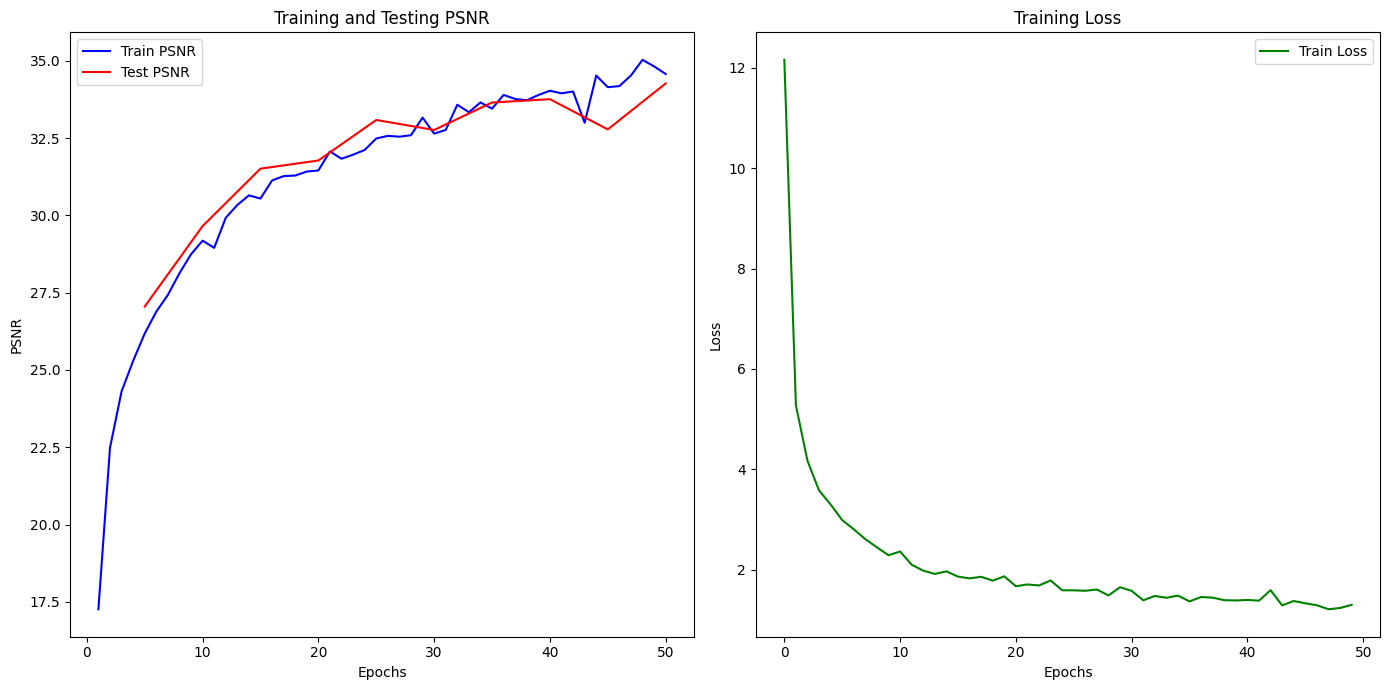

In [ ]:
plt.figure(figsize=(14, 7))

# Plot the PSNRs
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, epochs + 1), train_psnrs, label='Train PSNR', color='blue')
plt.plot(np.arange(show_interval, epochs + 1, show_interval), test_psnrs, label='Test PSNR', color='red')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('Training and Testing PSNR')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
best_psnr

34.26891276041667

In [ ]:
(np.argmax(test_psnrs)+1)*show_interval #number of epoch for the best model

50

Applying the model to yet unused frames

In [24]:
from models import SuperResolutionUNet

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [26]:
model = SuperResolutionUNet()

In [27]:
model.load_state_dict(torch.load('best_UNetSR_model.pth'))

<All keys matched successfully>

In [28]:
model = model.to(device)

In [31]:
# Last seconds of video. 0:49 - 1:04
low_res_frames_path_val = low_res_frames_path[588:770]
high_res_frames_path_val = high_res_frames_path[588:770]

In [32]:
low_res_frames_val = [cv2.imread(frame_path) for frame_path in low_res_frames_path_val]
high_res_frames_val = [cv2.imread(frame_path) for frame_path in high_res_frames_path_val]

In [33]:
low_res_frames_val_triple = []

for i in range(len(low_res_frames_val)-2):
  low_res_frames_val_triple.append([low_res_frames_val[i],
                                      low_res_frames_val[i+1],
                                      low_res_frames_val[i+2]])


high_res_frames_val_triple = []

for i in range(len(high_res_frames_val)-2):
  high_res_frames_val_triple.append([high_res_frames_val[i],
                                      high_res_frames_val[i+1],
                                      high_res_frames_val[i+2]])

In [34]:
dataset_val = VideoFramesDataset(low_res_frames_val_triple,
                                  high_res_frames_val_triple,
                                  transform=transform)

In [35]:
dataloader_val = DataLoader(dataset_val, batch_size=4, shuffle=False)

In [36]:
num_val_batches = len(dataloader_val)
val_psnr = 0

with torch.no_grad():
  for data_val in dataloader_val:
    low_res_seq, high_res_seq = data_val
    low_res_seq, high_res_seq = low_res_seq.to(device), high_res_seq.to(device)
    low_res_seq = nn.Upsample(scale_factor=(1,2,2), mode='nearest')(low_res_seq)
    outputs = model(low_res_seq)
    output_psnr_val = outputs[:,1,:,:,:]
    high_res_psnr_val = high_res_seq[:,1,:,:,:]
    b, c, h, w = output_psnr_val.size() # 4 x 3 (channel) x H x W
    val_psnr += utils.psnr(
        output_psnr_val.reshape(c, b*h, w),
        high_res_psnr_val.reshape(c, b*h, w)
        )

avg_val_psnr = val_psnr.item() / num_val_batches
print('PSNR on real data: ', avg_val_psnr)

PSNR on real data:  34.28882649739583
